In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import random
import numpy as np
from scipy.stats import t, beta, lognorm, expon, gamma, uniform
from scipy.stats import gaussian_kde, poisson, binom, norm, chi2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from scipy.linalg import inv, sqrtm

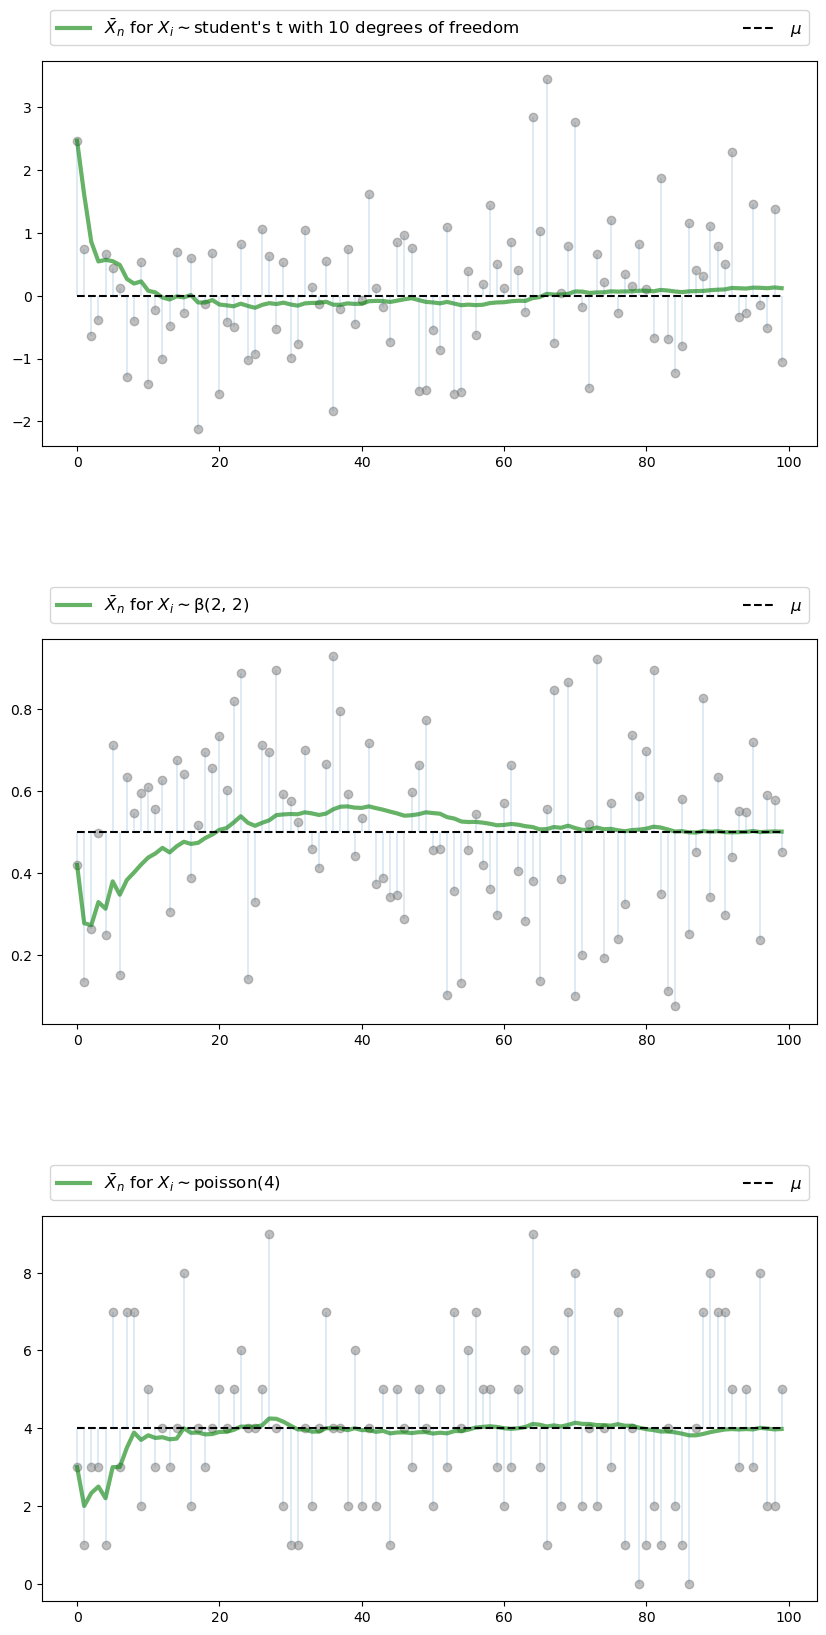

In [2]:
n = 100

# Arbitrary collection of distributions
distributions = {"student's t with 10 degrees of freedom": t(10),
                 "β(2, 2)": beta(2, 2),
                 "lognormal LN(0, 1/2)": lognorm(0.5),
                 "γ(5, 1/2)": gamma(5, scale=2),
                 "poisson(4)": poisson(4),
                 "exponential with λ = 1": expon(1)}

# Create a figure and some axes
num_plots = 3
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 20))

# Set some plotting parameters to improve layout
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 2,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}
plt.subplots_adjust(hspace=0.5)

for ax in axes:
    # Choose a randomly selected distribution
    name = random.choice(list(distributions.keys()))
    distribution = distributions.pop(name)

    # Generate n draws from the distribution
    data = distribution.rvs(n)

    # Compute sample mean at each n
    sample_mean = np.empty(n)
    for i in range(n):
        sample_mean[i] = np.mean(data[:i+1])

    # Plot
    ax.plot(list(range(n)), data, 'o', color='grey', alpha=0.5)
    axlabel = '$\\bar{X}_n$ for $X_i \sim$' + name
    ax.plot(list(range(n)), sample_mean, 'g-', lw=3, alpha=0.6, label=axlabel)
    m = distribution.mean()
    ax.plot(list(range(n)), [m] * n, 'k--', lw=1.5, label='$\mu$')
    ax.vlines(list(range(n)), m, data, lw=0.2)
    ax.legend(**legend_args, fontsize=12)

plt.show()

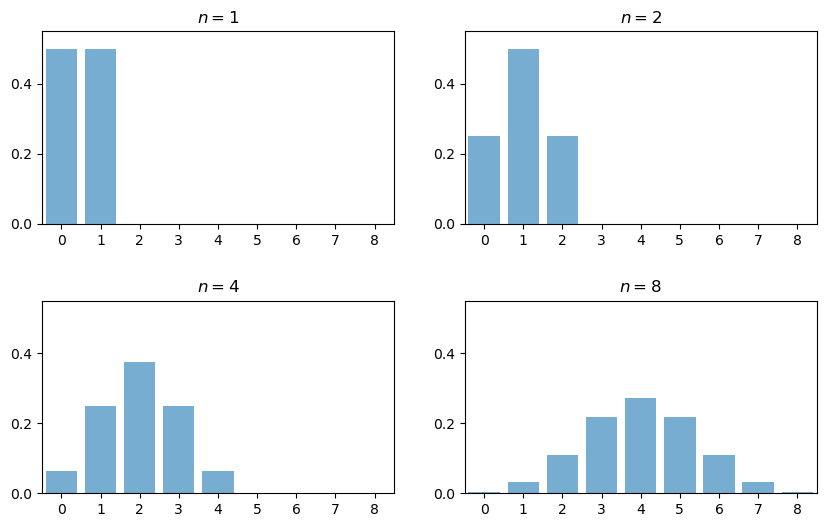

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
axes = axes.flatten()
ns = [1, 2, 4, 8]
dom = list(range(9))

for ax, n in zip(axes, ns):
    b = binom(n, 0.5)
    ax.bar(dom, b.pmf(dom), alpha=0.6, align='center')
    ax.set(xlim=(-0.5, 8.5), ylim=(0, 0.55),
           xticks=list(range(9)), yticks=(0, 0.2, 0.4),
           title=f'$n = {n}$')

plt.show()

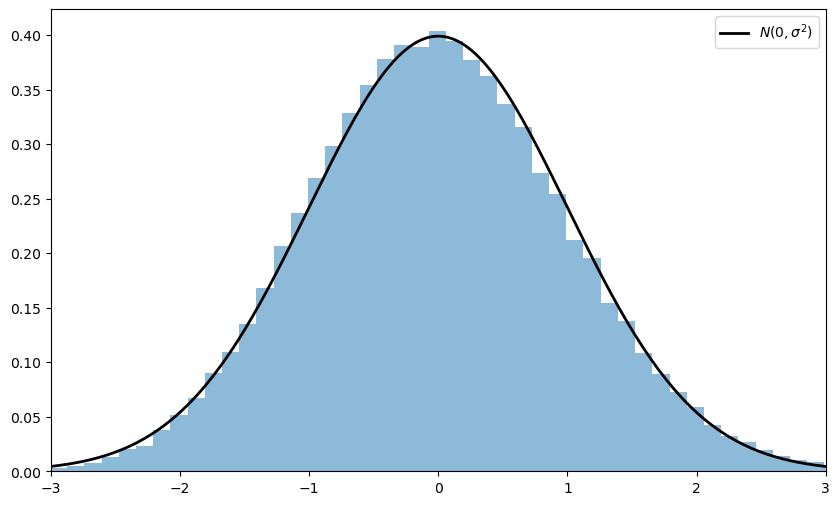

In [4]:
# Set parameters
n = 250                  # Choice of n
k = 100000               # Number of draws of Y_n
distribution = expon(2)  # Exponential distribution, λ = 1/2
μ, s = distribution.mean(), distribution.std()

# Draw underlying RVs. Each row contains a draw of X_1,..,X_n
data = distribution.rvs((k, n))
# Compute mean of each row, producing k draws of \bar X_n
sample_means = data.mean(axis=1)
# Generate observations of Y_n
Y = np.sqrt(n) * (sample_means - μ)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
xmin, xmax = -3 * s, 3 * s
ax.set_xlim(xmin, xmax)
ax.hist(Y, bins=60, alpha=0.5, density=True)
xgrid = np.linspace(xmin, xmax, 200)
ax.plot(xgrid, norm.pdf(xgrid, scale=s), 'k-', lw=2, label='$N(0, \sigma^2)$')
ax.legend()

plt.show()

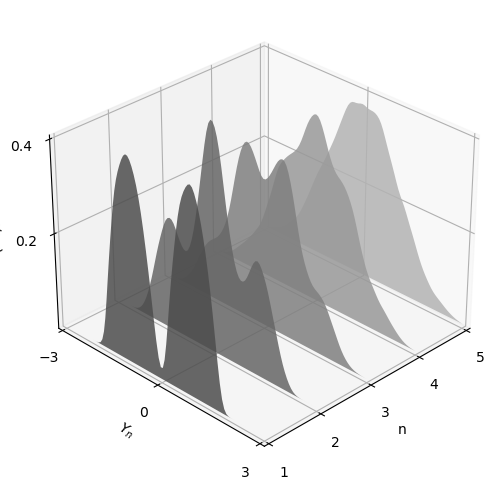

In [5]:
beta_dist = beta(2, 2)

def gen_x_draws(k):
    """
    Returns a flat array containing k independent draws from the
    distribution of X, the underlying random variable.  This distribution
    is itself a convex combination of three beta distributions.
    """
    bdraws = beta_dist.rvs((3, k))
    # Transform rows, so each represents a different distribution
    bdraws[0, :] -= 0.5
    bdraws[1, :] += 0.6
    bdraws[2, :] -= 1.1
    # Set X[i] = bdraws[j, i], where j is a random draw from {0, 1, 2}
    js = np.random.randint(0, 2, size=k)
    X = bdraws[js, np.arange(k)]
    # Rescale, so that the random variable is zero mean
    m, sigma = X.mean(), X.std()
    return (X - m) / sigma

nmax = 5
reps = 100000
ns = list(range(1, nmax + 1))

# Form a matrix Z such that each column is reps independent draws of X
Z = np.empty((reps, nmax))
for i in range(nmax):
    Z[:, i] = gen_x_draws(reps)
# Take cumulative sum across columns
S = Z.cumsum(axis=1)
# Multiply j-th column by sqrt j
Y = (1 / np.sqrt(ns)) * S

# Plot
ax = plt.figure(figsize = (10, 6)).add_subplot(projection='3d')

a, b = -3, 3
gs = 100
xs = np.linspace(a, b, gs)

# Build verts
greys = np.linspace(0.3, 0.7, nmax)
verts = []
for n in ns:
    density = gaussian_kde(Y[:, n-1])
    ys = density(xs)
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts, facecolors=[str(g) for g in greys])
poly.set_alpha(0.85)
ax.add_collection3d(poly, zs=ns, zdir='x')

ax.set(xlim3d=(1, nmax), xticks=(ns), ylabel='$Y_n$', zlabel='$p(y_n)$',
       xlabel=("n"), yticks=((-3, 0, 3)), ylim3d=(a, b),
       zlim3d=(0, 0.4), zticks=((0.2, 0.4)))
ax.invert_xaxis()
# Rotates the plot 30 deg on z axis and 45 deg on x axis
ax.view_init(30, 45)
plt.show()

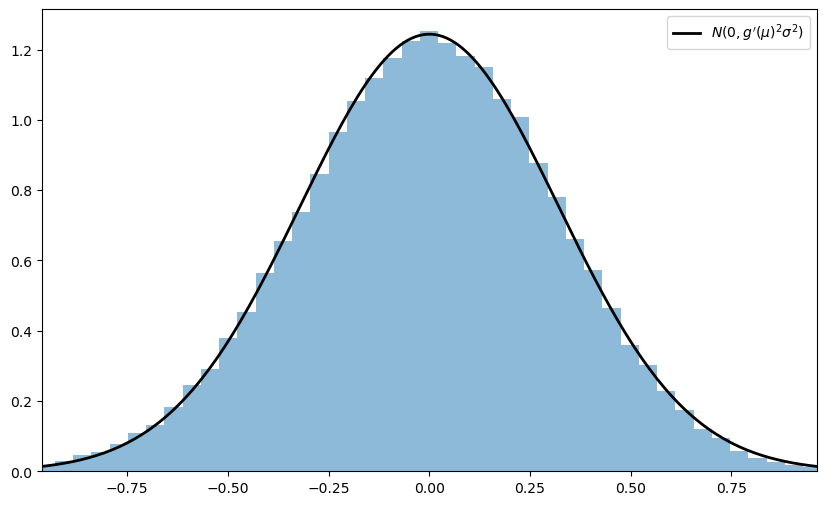

In [6]:
"""
Illustrates the delta method, a consequence of the central limit theorem.
"""

# Set parameters
n = 250
replications = 100000
distribution = uniform(loc=0, scale=(np.pi / 2))
μ, s = distribution.mean(), distribution.std()

g = np.sin
g_prime = np.cos

# Generate obs of sqrt{n} (g(X_n) - g(μ))
data = distribution.rvs((replications, n))
sample_means = data.mean(axis=1)  # Compute mean of each row
error_obs = np.sqrt(n) * (g(sample_means) - g(μ))

# Plot
asymptotic_sd = g_prime(μ) * s
fig, ax = plt.subplots(figsize=(10, 6))
xmin = -3 * g_prime(μ) * s
xmax = -xmin
ax.set_xlim(xmin, xmax)
ax.hist(error_obs, bins=60, alpha=0.5, density=True)
xgrid = np.linspace(xmin, xmax, 200)
lb = "$N(0, g'(\mu)^2  \sigma^2)$"
ax.plot(xgrid, norm.pdf(xgrid, scale=asymptotic_sd), 'k-', lw=2, label=lb)
ax.legend()
plt.show()

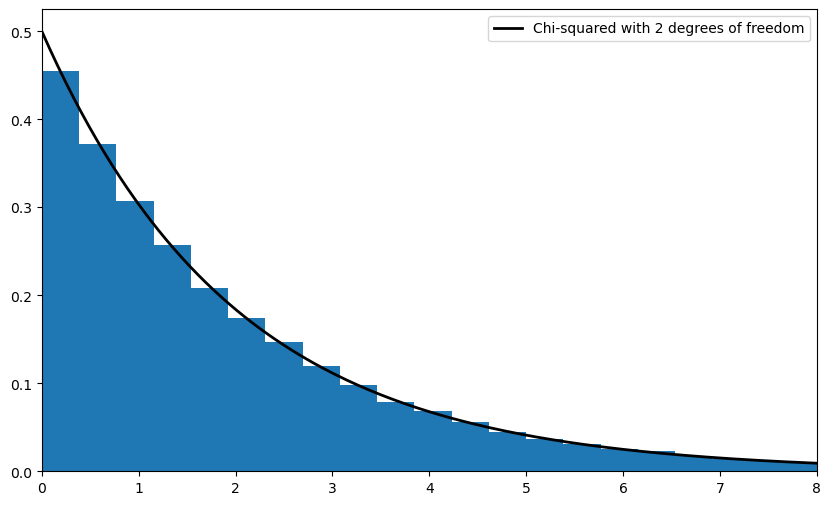

In [7]:
# Set parameters
n = 250
replications = 50000
dw = uniform(loc=-1, scale=2)  # Uniform(-1, 1)
du = uniform(loc=-2, scale=4)  # Uniform(-2, 2)
sw, su = dw.std(), du.std()
vw, vu = sw**2, su**2
Σ = ((vw, vw), (vw, vw + vu))
Σ = np.array(Σ)

# Compute Σ^{-1/2}
Q = inv(sqrtm(Σ))

# Generate observations of the normalized sample mean
error_obs = np.empty((2, replications))
for i in range(replications):
    # Generate one sequence of bivariate shocks
    X = np.empty((2, n))
    W = dw.rvs(n)
    U = du.rvs(n)
    # Construct the n observations of the random vector
    X[0, :] = W
    X[1, :] = W + U
    # Construct the i-th observation of Y_n
    error_obs[:, i] = np.sqrt(n) * X.mean(axis=1)

# Premultiply by Q and then take the squared norm
temp = Q @ error_obs
chisq_obs = np.sum(temp**2, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
xmax = 8
ax.set_xlim(0, xmax)
xgrid = np.linspace(0, xmax, 200)
lb = "Chi-squared with 2 degrees of freedom"
ax.plot(xgrid, chi2.pdf(xgrid, 2), 'k-', lw=2, label=lb)
ax.legend()
ax.hist(chisq_obs, bins=50, density=True)
plt.show()